This notebook shows the process of income prediction based on NURSERY dataset when fairness through unawareness approach is applied. This means that only the protected attributes are removed from the dataset.

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../')

In the following there's the import of the dataset and the preliminary work in order to fix the attributes, fill the NaN values and finally make the dataset ready for the analytics job

In [3]:
nursery_dataset = pd.read_csv('./nursery.csv', sep=',')

In [4]:
nursery_dataset

parents   has_nurs      form children     housing     finance  \
0           usual     proper  complete        1  convenient  convenient   
1           usual     proper  complete        1  convenient  convenient   
2           usual     proper  complete        1  convenient  convenient   
3           usual     proper  complete        1  convenient  convenient   
4           usual     proper  complete        1  convenient  convenient   
...           ...        ...       ...      ...         ...         ...   
12955  great_pret  very_crit    foster     more    critical      inconv   
12956  great_pret  very_crit    foster     more    critical      inconv   
12957  great_pret  very_crit    foster     more    critical      inconv   
12958  great_pret  very_crit    foster     more    critical      inconv   
12959  great_pret  very_crit    foster     more    critical      inconv   

              social       health  output  
0            nonprob  recommended       1  
1            nonprob     priority       1  
2            nonprob    not_recom       0  
3      slightly_prob  recommended       1  
4      slightly_prob     priority       1  
...              ...          ...     ...  
12955  slightly_prob     priority       0  
12956  slightly_prob    not_recom       0  
12957    problematic  recommended       0  
12958    problematic     priority       0  
12959    problematic    not_recom       0  

[12960 rows x 9 columns]

In [5]:
from fairness.pre_processing import categorical_to_numeric_converter, fix_attributes


new_nursery_dataset = categorical_to_numeric_converter(nursery_dataset)

At this point there's the protected attributes removal from the dataset. In this case we have chosen the following variable to be protected, according to the domain of the dataset:
* children

In [6]:
protected_attributes = ['children']

In [7]:
new_nursery_dataset.drop(columns=protected_attributes, inplace=True)

In [8]:
nursery_dataset

parents  has_nurs  form  housing  finance  social  health  output
0            2         3     0        0        0       0       2       1
1            2         3     0        0        0       0       1       1
2            2         3     0        0        0       0       0       0
3            2         3     0        0        0       2       2       1
4            2         3     0        0        0       2       1       1
...        ...       ...   ...      ...      ...     ...     ...     ...
12955        0         4     2        1        1       2       1       0
12956        0         4     2        1        1       2       0       0
12957        0         4     2        1        1       1       2       0
12958        0         4     2        1        1       1       1       0
12959        0         4     2        1        1       1       0       0

[12960 rows x 8 columns]

After the pre-processing step and after the protected attributes removal it's important to move to the training and prediction step

In [9]:
from sklearn.model_selection import train_test_split

X = new_nursery_dataset.drop(columns=['output'], inplace=False)
y = new_nursery_dataset['output']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

After the split of the dataset, the next step is to perform the calculations of the best parameters for the several models we want to use for the prediction step.Since this is a problem of multiclass classification, the chosen models are the following:

* RandomForest Classifier
* Logistic Regression
* DecisionTree Classifier

The best params for the RandomForest Classifier are:  {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 40, 'n_estimators': 40}


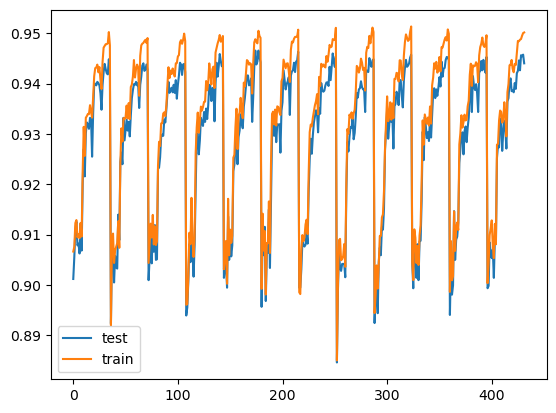

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

random_forest_model = RandomForestClassifier()
random_forest_params = {'n_estimators': range(10, 100, 10), 'criterion': ['gini', 'entropy', 'log_loss'], 
                        'max_depth': range(10, 50, 10), 'max_leaf_nodes': range(10, 50, 10)}

grid_search = GridSearchCV(random_forest_model, param_grid=random_forest_params, cv=10, return_train_score=True)
random_forest = grid_search.fit(X_train, y_train)

print("The best params for the RandomForest Classifier are: ", random_forest.best_params_)

test_scores = random_forest.cv_results_['mean_test_score']
train_scores = random_forest.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for random_forest:  0.9504325461772271


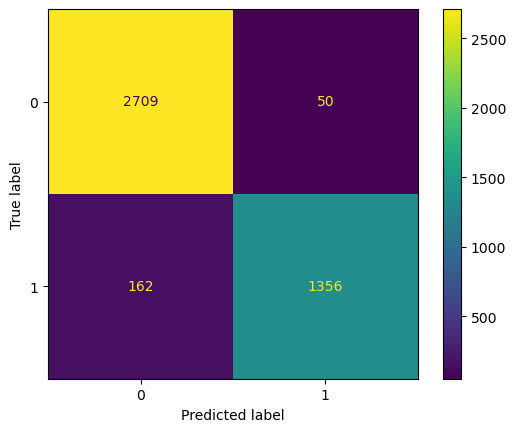

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

predicted_result = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for random_forest: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=random_forest.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=random_forest.classes_)
display.plot()
plt.show()

The best params for the Logistic Regression are:  {'penalty': 'l1', 'solver': 'saga'}


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
130 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_solver
    raise ValueError(
ValueError: Sol

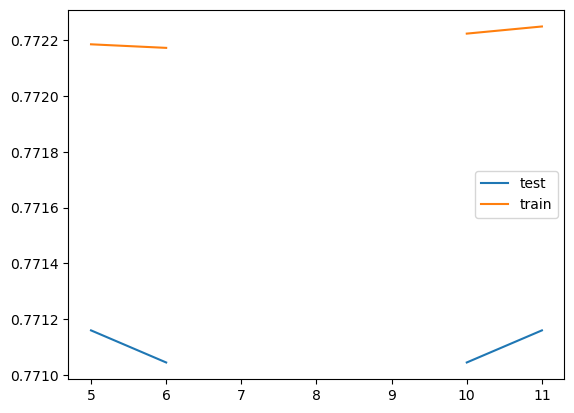

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logistic_regression_model = LogisticRegression(multi_class='multinomial')
logistic_regression_params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

grid_search = GridSearchCV(logistic_regression_model, param_grid=logistic_regression_params, cv=10, return_train_score=True)
logistic_regression = grid_search.fit(X_train, y_train)

print("The best params for the Logistic Regression are: ", logistic_regression.best_params_)

test_scores = logistic_regression.cv_results_['mean_test_score']
train_scores = logistic_regression.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for logistic regression:  0.7839607201309329


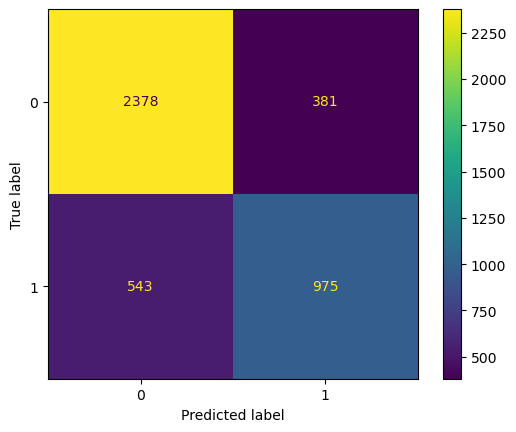

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_result = logistic_regression.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for logistic regression: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=logistic_regression.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=logistic_regression.classes_)
display.plot()
plt.show()


The best params for DecisionTree Classifier are:  {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 40}


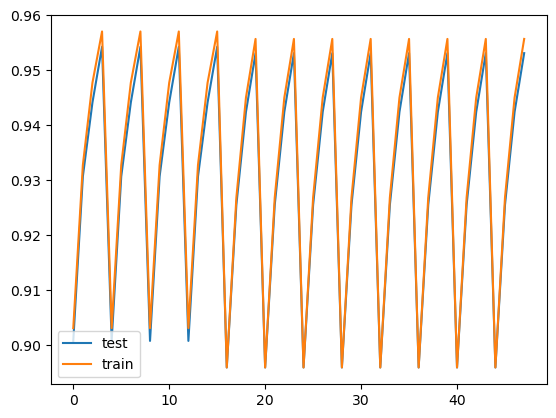

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

decision_tree_model = DecisionTreeClassifier()
decision_tree_params = {'criterion': ['gini', 'entropy', 'log_loss'], 
                        'max_depth': range(10, 50, 10), 'max_leaf_nodes': range(10, 50, 10)}

grid_search = GridSearchCV(decision_tree_model, param_grid=decision_tree_params, cv=10, return_train_score=True)
decision_tree = grid_search.fit(X_train, y_train)
best_params = decision_tree.best_params_
print("The best params for DecisionTree Classifier are: ", best_params)

test_scores = decision_tree.cv_results_['mean_test_score']
train_scores = decision_tree.cv_results_['mean_train_score'] 

plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.legend(loc='best')
plt.show()

Accuracy for decision tree classifier:  0.9548749123217208


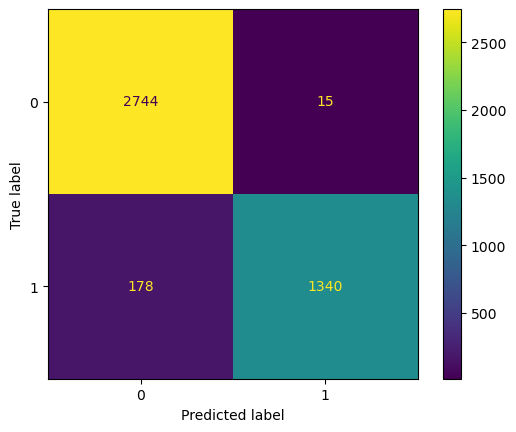

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_result = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, predicted_result)
print("Accuracy for decision tree classifier: ", accuracy)

matrix = confusion_matrix(y_test, predicted_result, labels=decision_tree.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=decision_tree.classes_)
display.plot()
plt.show()
